In [2]:
from casadi import *
import os
from dynamic_model import *
import Bezier
from readDataFcn import getTrack
import matplotlib.pyplot as plt
import yaml
from scipy.interpolate import CubicSpline
%matplotlib qt

In [3]:
import os
os.getcwd()

'/home/pw/catkin_ws/src/mpcc/scripts/Acadosmodel'

In [4]:
table = Bezier.generatelookuptable('tracks/simpleoval')
Bezier.plot_track(table)

table generated with npoints =  2312
Variables stored in following order =  ['sval', 'tval', 'xtrack', 'ytrack', 'phitrack', 'cos(phi)', 'sin(phi)', 'g_upper', 'g_lower']


TypeError: tuple indices must be integers or slices, not tuple

In [8]:
%matplotlib qt
def interpolate(waypoints):
    #interpolates with cubic bezier curves with cyclic boundary condition
    n = len(waypoints)
    M = np.zeros([n,n])

    #build M
    tridiagel = np.matrix([[1, 4, 1]])
    for idx in range(n-2):
        M[idx+1:idx+2, idx:idx+3] = tridiagel

    M[0,0:2]= tridiagel[:,1:3]
    M[-1,-2:]= tridiagel[:,0:2]
    M[0:2,-1] = tridiagel[:,0].reshape(1,-1)
    M[-1,0] = tridiagel[:,0].reshape(1,-1)


    #build sol vector
    s =np.zeros([n,2])
    for idx in range(n-1):
        s[idx,:] = 2*(2*waypoints[idx,:] + waypoints[idx+1,:])
    s[-1:] = 2*(2*waypoints[-1,:] + waypoints[0,:])

    #solve for a & b
    Ax = np.linalg.solve(M,s[:,0])
    Ay = np.linalg.solve(M,s[:,1])

    a = np.vstack([Ax,Ay])
    b = np.zeros([2,n])

    b[:,:-1] = 2*waypoints.T[:,1:] - a[:,1:]
    b[:,-1] = 2*waypoints.T[:,0] - a[:,0]

    return a, b

def compute_t(coef, order, s):
    res = 0
    for idx in range(order):
        res += coef[idx]*np.power(s,order-idx)
    return res

def eval_raw(waypoints, a, b, t):
    segment = np.floor(t)
    segment = int(segment)
    n = len(waypoints)
    if segment>=n:
        t =n-0.0001
        segment = n-1
    elif t<0:
        t = 0
    t_val = t-segment
    coords = np.power(1 - t_val, 3) * waypoints.T[:,segment] + 3 * np.power(1 - t_val, 2) * t_val * a[:,segment]\
    + 3 * (1 - t_val) * np.power(t_val, 2) * b[:,segment] + np.power(t_val, 3) * waypoints.T[:,int(np.mod(segment+1,n))]

    return coords

def getangle_raw(waypoints, a, b, t):
    nwp = len(waypoints)
    der = eval_raw(waypoints, a, b, np.mod(t+0.1, nwp)) - eval_raw(waypoints, a, b, np.mod(t,nwp))
    phi = np.arctan2(der[1],der[0])
    return phi

def fit_st(waypoints, a, b):
    #using two revolutions to account for horizon overshooting end of lap
    
    #fit  the s-t rel.
    nwp = len(waypoints)
    npoints = 20 * nwp
    #compute approx max distance 
    tvals = np.linspace(0, nwp, npoints+1)
    coords =[]
    for t in tvals:
        coords.append(eval_raw(waypoints, a, b, t))
    coords = np.array(coords)
    dists = []
    dists.append(0)
    for idx in range(npoints):
        dists.append(np.sqrt(np.sum(np.square(coords[idx,:]-coords[np.mod(idx+1,npoints-1),:]))))
    dists = np.cumsum(np.array(dists))
    smax = dists[-1]
    
    #--------fit  the s-t rel. to two track revolutions------
    npoints = 2 * 20 * nwp

    #compute approx distance to arc param
    tvals = np.linspace(0, 2*nwp, npoints+1)

    coords =[]
    for t in tvals:
        coords.append(eval_raw(waypoints, a, b, np.mod(t, nwp)))
    coords = np.array(coords)

    distsr = []
    distsr.append(0)
    for idx in range(npoints):
        distsr.append(np.sqrt(np.sum(np.square(coords[idx,:]-coords[np.mod(idx+1,npoints-1),:]))))
    dists = np.cumsum(np.array(distsr))
    #coeffs = coef.value
    #print(coords[:])
    #print(tvals.shape)
    ts_inverse = CubicSpline(dists, tvals)
    
    
    svals = np.linspace(0, 2*smax, npoints)
    t_corr = ts_inverse(svals)
    #t_corr = compute_t(coeffs,order,svals)


    plt.figure()
    plt.plot(t_corr, svals)
    plt.plot(tvals, dists, linestyle = '--')
    plt.xlabel("t (Bezier param) [-]")
    plt.ylabel("s (approx. distance traveled) [m] ")

    return ts_inverse, smax

def getwaypoints(track):
    #placeholder for now
    scaler = 10
    trackx = scaler*np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, \
                  0.8 ,0.8 ,0.8 ,0.8, 0.75, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.0, 0.0, 0.0, 0.0 ])
    tracky = scaler*np.array([0.05, 0.3, 0.4, 0.2, 0.2, 0.0, 0.0, 0.0, 0.05, \
                    0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.5, 0.3, 0.3, 0.5, 0.5, 0.5, 0.45, 0.4, 0.3, 0.2, 0.1 ])
    waypoints = np.vstack([trackx,tracky]).T

    waypoints = np.genfromtxt(track + '.csv', delimiter=',')
    return waypoints

In [9]:
#load track
track = "tracks/simpleoval"
waypoints = getwaypoints(track)
nwp = len(waypoints)
plt.scatter(waypoints[:,0], waypoints[:,1])
#trackwidth
r = 0.1
#abez,bbez coeffs
a, b = interpolate(waypoints)
ts_inverse, smax = fit_st(waypoints, a, b)

lutable_density = 20 #[p/m]

npoints = int(np.floor(2*smax * lutable_density))
print(npoints)

svals = np.linspace(0, 2*smax, npoints)
tvals = ts_inverse(svals)

#  entries :
names_table = ['sval', 'tval', 'xtrack', 'ytrack', 'phitrack', 'cos(phi)', 'sin(phi)', 'g_upper', 'g_lower']
table = []
for idx in range(npoints):
    track_point = eval_raw(waypoints, a, b, np.mod(tvals[idx],nwp))
    phi = getangle_raw(waypoints, a, b, tvals[idx])
    n = [-np.sin(phi), np.cos(phi)]
    g_upper = r + track_point[0]*n[0] + track_point[1]*n[1]
    g_lower = -r + track_point[0]*n[0] + track_point[1]*n[1]
    table.append([svals[idx], tvals[idx], track_point[0], track_point[1], phi, np.cos(phi), np.sin(phi), g_upper, g_lower])

table = np.array(table)
#plot_track(table)
print("Variables stored in following order = ", names_table)
np.savetxt(str(track) + '_lutab.csv', table, delimiter = ', ')

dict = {'smax': float(smax)}
with open(r''+track+'_params.yaml', 'w') as file:
    documents = yaml.dump(dict, file)

462
Variables stored in following order =  ['sval', 'tval', 'xtrack', 'ytrack', 'phitrack', 'cos(phi)', 'sin(phi)', 'g_upper', 'g_lower']


In [6]:
smax

NameError: name 'smax' is not defined

In [7]:
eval_raw(waypoints, a, b, 0)

NameError: name 'eval_raw' is not defined

In [20]:
npoints = 200
a, b = interpolate(waypoints)
coords =[]
tvals = np.linspace(0, len(waypoints), npoints+1)
for t in tvals:
    coords.append(eval_raw(waypoints, a, b, t))

coords = np.array(coords)
coords.shape

fig, ax = plt.subplots(1)
sct = ax.scatter(waypoints[:,0], waypoints[:,1])

In [21]:
sct.remove()
plt.show()

In [74]:
#downsample
downsampling = 20
coords = table[:, 2:4]
phis = table[::downsampling, 4]
svals = table[::downsampling, 0]
tvals = table[::downsampling, 1]
cos_phi = table[::downsampling, 5]
sin_phi = table[::downsampling, 6]
gvals = table[::downsampling, 7]


dists = []
dists.append(0)
npoints = len(coords)
for idx in range(npoints-1):
    dists.append(np.sqrt(np.sum(np.square(coords[idx,:]-coords[np.mod(idx+1,npoints-1),:]))))
dists = np.cumsum(np.array(dists))
dists = dists[::downsampling]
coords = coords[::downsampling]
npoints = len(coords)

plt.figure()
plt.plot(svals, dists)
plt.plot([0, svals[-1]], [0, svals[-1]])
plt.xlabel("t (Bezier param corrected) [m]")
plt.ylabel("s (approx. distance traveled) [m] ")
plt.legend(["arclength vs t_corr","x=y"])

plt.figure()
len_indicator = 0.05
downsampling = 10
plt.plot(table[:,2],table[:,3])
plt.scatter(table[::downsampling,2],table[::downsampling,3], marker = 'o' )
for idx in range(npoints):
    n = [-sin_phi[idx], cos_phi[idx]]
    g = gvals[idx]
    lm = 0.001
    baseupper = [(coords[idx,0]-lm ), (g-n[0]*(coords[idx,0]-lm )) / n[1]]
    endupper = [(coords[idx,0]+lm ), (g-n[0]*(coords[idx,0]+lm )) / n[1]]
    base = coords[idx,:]
    end = len_indicator * np.array([cos_phi[idx], sin_phi[idx]]) + base
    plt.plot([base[0], end[0]],[base[1], end[1]], color = 'r')
    #plt.plot([baseupper[0], endupper[0]],[baseupper[1], endupper[1]], color = 'g')
plt.show(block=False)


In [29]:
dists

array([ 0.        ,  0.1984749 ,  0.3986771 ,  0.59838296,  0.79700848,
        0.9952915 ,  1.18969176,  1.38956188,  1.58858645,  1.78875253,
        1.98886343,  2.18905512,  2.38925822,  2.58946994,  2.78965431,
        2.9898368 ,  3.18996146,  3.38995369,  3.58959335,  3.78878301,
        3.98857144,  4.1886323 ,  4.38879225,  4.58899766,  4.789099  ,
        4.98928677,  5.18946982,  5.38957978,  5.58950904,  5.78892655,
        5.98832714,  6.18822266,  6.38831363,  6.5884839 ,  6.78867102,
        6.98886877,  7.18907419,  7.38928889,  7.5895047 ,  7.78972052,
        7.98993526,  8.19014117,  8.39033939,  8.59052785,  8.7906978 ,
        8.99078614,  9.19067401,  9.39006284,  9.58949323,  9.78942975,
        9.98954173, 10.1897251 , 10.38990719, 10.59002003, 10.79023117,
       10.99040611, 11.19047754, 11.50623412, 11.81699493])

In [23]:
np.mod(6,5.5)

0.5

In [35]:
table[-1, :]

array([11.6025332 , 18.        ,  0.24994321,  0.2500401 ,  0.        ,
        1.        ,  0.        ,  0.3500401 ,  0.1500401 ])

In [34]:
table[0,:]

array([ 0.        ,  0.        ,  0.25      ,  0.25      , -0.49645607,
        0.8792761 , -0.47631244,  0.43889713,  0.23889713])

In [44]:
np.hstack((trackx, trackx))

array([0.5, 1. , 2. , 3. , 4. , 5. , 6. , 7. , 7.5, 8. , 8. , 8. , 8. ,
       7.5, 7. , 6. , 5. , 4. , 3. , 2. , 1. , 0.5, 0. , 0. , 0. , 0. ,
       0.5, 1. , 2. , 3. , 4. , 5. , 6. , 7. , 7.5, 8. , 8. , 8. , 8. ,
       7.5, 7. , 6. , 5. , 4. , 3. , 2. , 1. , 0.5, 0. , 0. , 0. , 0. ])

In [45]:
trackx.shape

(26,)

In [2]:
model, constraints = dynamic_model(paramfile, track_lu_table)


NameError: name 'paramfile' is not defined

In [5]:
array = np.array([[1,2,3,4,5],[11,12,31,14,15]]).T

In [12]:
np.vstack((array[:,1],array[:,0])).T

array([[11,  1],
       [12,  2],
       [31,  3],
       [14,  4],
       [15,  5]])

Text(0.5, 0, 'lateral velocity vy [m/s]')

<Figure size 432x288 with 0 Axes>

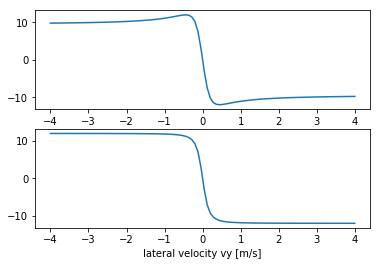

In [31]:

import numpy as np
import matplotlib.pyplot as plt
import yaml

modelparams = "modelparams.yaml"
#loadparameters
with open(modelparams) as file:
    params = yaml.load(file, Loader= yaml.FullLoader)

m = params['m'] #[kg]
lf = params['lf'] #[m]
lr = params['lr'] #[m]
Iz = params['Iz'] #[kg*m^3]

#pajecka and motor coefficients
Bf = params['Bf']
Br = params['Br']
Cf = params['Cf']
Cr = params['Cr']
Cm1 = params['Cm1']
Cm2 = params['Cm2']
Cr = params['Cr']
Cd = params['Cd']
Df = params['Df']
Dr = params['Dr']

vy_vals = np.linspace(-4, 4, 100)
vx = 2
omega = 0
delta = 0

ffy_vals = Df*np.sin(Cf*np.arctan(-Bf*np.arctan(vy_vals/vx)))
fry_vals = Dr*np.sin(Cr*np.arctan(Br*np.arctan(-vy_vals/vx)))

plt.figure()
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1)
ax1.plot(vy_vals,ffy_vals)
ax1.set_xlabel("lateral velocity vy [m/s]")
ax1.set_ylabel("lateral tire force Ffy [N]")
ax2.plot(vy_vals, fry_vals)
ax2.set_xlabel("lateral velocity vy [m/s]")
ax2.set_ylabel("lateral tire force Fry [N]")

In [38]:
np.savetxt("yallah.csv", ffy_vals,  delimiter = ",")

In [9]:
from casadi import *
import Bezier


'''
#load track
waypoints = Bezier.getwaypoints(track)
#abez,bbez coeffs
a_bez, b_bez = Bezier.interpolate(waypoints)
order_inverse = 4
norm_inverse = 2
coeffs = Bezier.fit_st(order_inverse, norm_inverse, waypoints)
'''
# define casadi struct
model = types.SimpleNamespace()
constraints = types.SimpleNamespace()

model_name = "f110_dynamic_model"
model.name = model_name
#loadparameters
m = 2 #[kg]
lf = 0.1 #[m]
lr = 0.1 #[m]
Iz = 1 #[kg*m^3]

#pajecka and motor coefficients
Bf = 1
Br = 1
Cf = 1
Cr = 1
Cm1 = 1
Cm2 = 2
Cr = 1
Cd = 1
Df = 1
Dr = 1


#parameter vector
xt =  SX.sym("xt")
yt =  SX.sym("yt")
phit = SX.sym("phit")
sin_phit = SX.sym("sin_phit")
cos_phit = SX.sym("cos_phit")
gt_upper = SX.sym("gt_upper")
gt_lower = SX.sym("gt_lower")
#stores linearization point
theta_hat = SX.sym("theta_hat")
Qc = SX.sym("Qc")
Ql = SX.sym("Ql")
Q_theta = SX.sym("Q_theta")

#cost on smoothnes of motorinput
R_d = SX.sym("R_d")

#cost on smoothness of steering_angle
R_delta = SX.sym("R_delta")

p = vertcat(xt, yt, phit, sin_phit, cos_phit, gt_upper, gt_lower, theta_hat, Qc, Ql, Q_theta, R_d, R_delta)


#single track model with pajecka tireforces as in  Optimization-Based Autonomous Racing of 1:43 Scale RC Cars Alexander Liniger, Alexander Domahidi and Manfred Morari
#pose
posx = SX.sym("posx")
posy = SX.sym("posy")


#vel (long and lateral)
vx = SX.sym("vx")
vy = SX.sym("vy")

#body angular Rate
omega = SX.sym("omega")
#heading
phi = SX.sym("phi")

#steering_angle
delta = SX.sym("delta")
deltadot = SX.sym("delta")
#motorinput
d = SX.sym("d")
ddot = SX.sym("ddot")

#inputvector
u = vertcat(ddot, deltadot, thetadot)

#dynamic forces
Frx = SX.sym("Frx")
Fry = SX.sym("Fry")
Ffx = SX.sym("Ffx")
Ffy = SX.sym("Ffy")

#arclength progress
theta = SX.sym("theta")

#temporal derivatives
posxdot = SX.sym("xdot")
posydot = SX.sym("ydot")
vxdot = SX.sym("vxdot")
vydot = SX.sym("vydot")
phidot = SX.sym("phidot")
omegadot = SX.sym("omegadot")
deltadot = SX.sym("deltadot")
thetadot = SX.sym("thetadot")

#car state Dynamics
x = vertcat(
    posx,
    posy,
    phi,
    vx,
    vy,
    omega,
    theta,
    d,
    delta
    )

xdot = vertcat(
    posxdot,
    posydot,
    phidot,
    vxdot,
    vydot,
    omegadot,
    thetadot,
    ddot,
    deltadot
    )

#front lateral tireforce
alphaf = -atan((omega*lf + vy)/vx) + delta
Ffy = Df*sin(Cf*atan(Bf*alphaf))

#rear lateral tireforce
alphar = atan((omega*lr - vy)/vx)
Fry = Dr*sin(Cf*atan(Br*alphar))

#rear longitudinal forces
Frx = (Cm1-Cm2*vx) * d - Cr -Cd*vx**2

f_expl = vertcat(
    vx*cos(phi) - vy * sin(phi),
    vx*sin(phi) + vy * cos(phi),
    omega,
    1/m * (Frx - Fry*sin(delta) + m*vy*omega),
    1/m * (Fry + Fry*cos(delta) - m*vx*omega),
    1/Iz * (Ffy*lf*cos(delta) - Fry*lr),
    thetadot,
    ddot,
    deltadot
    )


model.f_expl_expr = f_expl
model.f_impl_expr = xdot - f_expl
model.x = x
model.xdot = xdot
model.u = u
model.p = p

#boxconstraints
model.d_min = -1.0
model.d_max = 1.0

model.ddot_min = -10.0
model.ddot_max = 10.0

model.delta_min = -0.40  # minimum steering angle [rad]
model.delta_max = 0.40  # maximum steering angle [rad]

model.deltadot_min = -2  # minimum steering angle [rad]
model.deltadot_max = 2 # maximum steering angle [rad]


#halfspace constraints on x capturing the track at each stage
n = vertcat(-sin_phit, cos_phit)
constraints.h_upper = vertcat(0,0)
g_upper = vertcat(gt_upper, -gt_lower)
model.con_h_expr = vertcat(n[0]*x[0]+n[1]*x[1]-g_upper[0], -n[0]*x[0]-n[1]*x[1]-g_upper[1])

#compute approximate linearized contouring and lag error
xt_hat = xt + cos_phit * ( theta - theta_hat)
yt_hat = yt + sin_phit * ( theta - theta_hat)

e_cont = sin_phit * (posx - xt_hat) - cos_phit * (posy - yt_hat)
e_lag = -cos_phit * (posx - xt_hat) - sin_phit * (posy - yt_hat)

error = vertcat(e_cont, e_lag)
#set up stage cost
Q = diag(vertcat(Qc, Ql))
model.stage_cost = bilin(Q, error, error) - Q_theta * thetadot + bilin(R_d , ddot, ddot) + bilin(R_delta , deltadot, deltadot)

In [11]:
model.con_h_expr.shape


(2, 1)

In [2]:
# define casadi struct
model = types.SimpleNamespace()
constraints = types.SimpleNamespace()

model_name = "f110_dynamic_model"
#loadparameters
m = 2 #[kg]
lf = 0.1 #[m]
lr = 0.1 #[m]
Iz = 1 #[kg*m^3]

#pajecka and motor coefficients
Bf = 1
Br = 1
Cf = 1
Cr = 1
Cm1 = 1
Cm2 = 2
Cr = 1
Cd = 1
Df = 1
Dr = 1


#parameter vector
xt =  SX.sym("xt")
yt =  SX.sym("yt")
phit = SX.sym("phit")
sin_phit = SX.sym("sin_phit")
cos_phit = SX.sym("cos_phit")
gt_upper = SX.sym("gt_upper")
gt_lower = SX.sym("gt_lower")
#stores linearization point
theta_hat = SX.sym("theta_hat")
Qc = SX.sym("Qc")
Ql = SX.sym("Ql")
R = SX.sym("R")

#single track model with pajecka tireforces as in  Optimization-Based Autonomous Racing of 1:43 Scale RC Cars Alexander Liniger, Alexander Domahidi and Manfred Morari
#pose
posx = SX.sym("posx")
posy = SX.sym("posy")


#vel (long and lateral)
vx = SX.sym("vx")
vy = SX.sym("vy")

#body angular Rate
omega = SX.sym("omega")
#heading
phi = SX.sym("phi")

#virtual input projected track velocity
vt = SX.sym("vt")

#steering_angle
delta = SX.sym("delta")

#motorinput
d = SX.sym("d")

#dynamic forces
Frx = SX.sym("Frx")
Fry = SX.sym("Fry")
Ffx = SX.sym("Ffx")
Ffy = SX.sym("Ffy")

#arclength progress
theta = SX.sym("theta")

#temporal derivatives
posxdot = SX.sym("xdot")
posydot = SX.sym("ydot")
vxdot = SX.sym("vxdot")
vydot = SX.sym("vydot")
phidot = SX.sym("phidot")
omegadot = SX.sym("omegadot")
thetadot = SX.sym("thetadot")
deltadot = SX.sym("deltadot")

#car state Dynamics
x = vertcat(
    posx,
    posy,
    phi,
    vx,
    vy,
    omega,
    theta
    )

xdot = vertcat(
    posxdot,
    posydot,
    phidot,
    vxdot,
    vydot,
    omegadot,
    thetadot
    )



#front lateral tireforce
alphaf = -atan((omega*lf + vy)/vx) + delta
Ffy = Df*sin(Cf*atan(Bf*alphaf))

#rear lateral tireforce
alphar = atan((omega*lr - vy)/vx)
Fry = Dr*sin(Cf*atan(Br*alphar))

#rear longitudinal forces
Frx = (Cm1-Cm2*vx) * d - Cr -Cd*vx**2

f_expl = vertcat(
    vx*cos(phi) - vy * sin(phi),
    vx*sin(phi) + vy * cos(phi),
    omega,
    1/m * (Frx - Fry*sin(delta) + m*vy*omega),
    1/m * (Fry + Fry*cos(delta) - m*vx*omega),
    1/Iz * (Ffy*lf*cos(delta) - Fry*lr),
    vt
    )


model.f_expl_expr = f_expl
model.f_impl_expr = xdot - f_expl
model.x = x

#halfspace constraints on x capturing the track
n = vertcat(-sin_phit, cos_phit)
constraints.C = np.matrix([[n[0], n[1], 0, 0, 0, 0, 0],  [-n[0], -n[1], 0, 0, 0, 0, 0]])
constraints.ge_upper = vertcat(gt_upper, -gt_lower)


#compute approximate linearized contouring and lag error
xt_hat = xt + cos_phit * ( theta - theta_hat)
yt_hat = yt + sin_phit * ( theta - theta_hat)

e_cont = sin_phit * (posx - xt_hat) - cos_phit * (posy - yt_hat)
e_lag = -cos_phit * (posx - xt_hat) - sin_phit * (posy - yt_hat)

error = vertcat(e_cont, e_lag)
#set up stage cost
Q = diag(vertcat(Qc, Ql))
model.stage_cost = bilin(Q, error, error)


In [3]:
Q

SX(
[[Qc, 00], 
 [00, Ql]])

In [43]:
tvals = np.linspace(0, 1, 26)
kapparef_s = interpolant("kapparef_s","bspline", [tvals], waypoints[:,0].tolist())


RuntimeError: .../casadi/core/function_internal.cpp:70: Function name is not valid. A valid function name is a string starting with a letter followed by letters, numbers or non-consecutive underscores. It may also not match the keywords 'null', 'jac' or 'hess'. Got ''

In [23]:
xdot

MX(vertcat(posxdot, posydot, phidot, vxdot, vydot, omegadot))

In [48]:
# load track parameters
track="LMS_Track.txt"
[s0, _, _, _, kapparef] = getTrack(track)
length = len(s0)
pathlength = s0[-1]



In [51]:
# load track parameters
[s0, _, _, _, kapparef] = getTrack(track)
length = len(s0)
pathlength = s0[-1]
# copy loop to beginning and end
s0 = np.append(s0, [s0[length - 1] + s0[1:length]])
kapparef = np.append(kapparef, kapparef[1:length])
s0 = np.append([-s0[length - 2] + s0[length - 81 : length - 2]], s0)
kapparef = np.append(kapparef[length - 80 : length - 1], kapparef)

# compute spline interpolations
kapparef_s = interpolant("kapparef_s", "bspline", [s0], kapparef)

RuntimeError: .../casadi/core/function_internal.cpp:70: Function name is not valid. A valid function name is a string starting with a letter followed by letters, numbers or non-consecutive underscores. It may also not match the keywords 'null', 'jac' or 'hess'. Got ''

In [53]:
s0

array([-3.1307295, -3.1061956, -3.0436956, -2.9811956, -2.9186956,
       -2.8561956, -2.7936956, -2.7311956, -2.6686956, -2.6061956,
       -2.5816618, -2.557128 , -2.5325941, -2.5080603, -2.4835265,
       -2.4589926, -2.4344588, -2.409925 , -2.3853911, -2.3608573,
       -2.3363234, -2.3117896, -2.2872558, -2.2627219, -2.2381881,
       -2.2136543, -2.1891204, -2.1645866, -2.1400527, -2.1155189,
       -2.0909851, -2.0664512, -2.0419174, -2.0173836, -1.9928497,
       -1.9683159, -1.943782 , -1.9192482, -1.8947144, -1.8701805,
       -1.8456467, -1.8211129, -1.7586129, -1.6961129, -1.6336129,
       -1.5711129, -1.5086129, -1.4461129, -1.3836129, -1.3211129,
       -1.2586129, -1.1961129, -1.1336129, -1.0711129, -1.0086129,
       -0.9461129, -0.8836129, -0.8211129, -0.796579 , -0.7720452,
       -0.7475113, -0.7229775, -0.6984437, -0.6739098, -0.649376 ,
       -0.6248422, -0.6003083, -0.5757745, -0.5512407, -0.5267068,
       -0.502173 , -0.4776391, -0.4531053, -0.4285715, -0.3571